In [44]:
import torch
from torch import nn
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



cuda


Data folder path: D:\Programming\Projects\Facial_Emotion_Recognition\data
Random image path:..\data\train\angry\Training_56085499.jpg
Image class:angry
Image height:48
Image width: 48


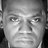

In [45]:
from pathlib import Path
from PIL import Image
import random

# go up one level to reach project root
image_path = Path("../data")

print(f"Data folder path: {image_path.resolve()}")

if not image_path.exists():
    raise FileNotFoundError(f"Data folder not found at {image_path.resolve()}")

# collect all jpgs (train/test/class/image.jpg)
image_path_list = list(image_path.glob("*/*/*.jpg"))

if not image_path_list:
    raise ValueError("No images found inside data folder")

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path:{random_image_path}")
print(f"Image class:{image_class}")
print(f"Image height:{img.height}")
print(f"Image width: {img.width}")
img


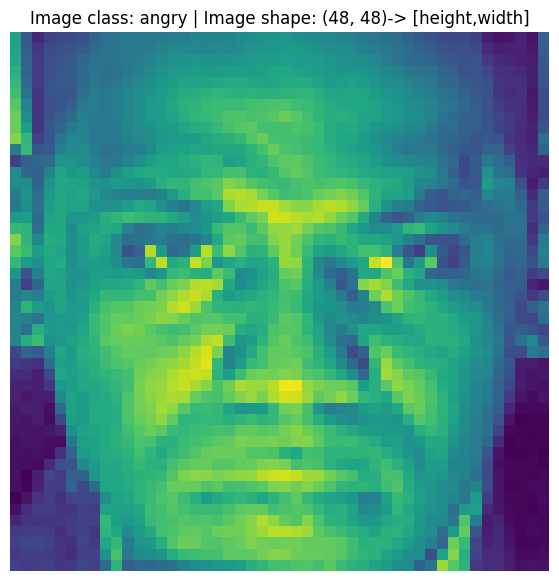

In [46]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}-> [height,width]")
plt.axis(False)

image_height = img_as_array.shape[0]
image_width = img_as_array.shape[1]

In [47]:
img_as_array.shape

(48, 48)

In [48]:
train_dir = image_path /"train"
test_dir = image_path/"test"

train_dir,test_dir

(WindowsPath('../data/train'), WindowsPath('../data/test'))

Transforming Data

In [49]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Training transformations (with mild augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),         # small left-right flips
    transforms.ToTensor(),                          # convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                     std=(0.5, 0.5, 0.5))

])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # <--- convert 1→3
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                     std=(0.5, 0.5, 0.5))

])

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [50]:
print("Length of training dataset:", len(train_data))
print("Length of test dataset:", len(test_data))

Length of training dataset: 28709
Length of test dataset: 7178


In [51]:
import torch
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, dropout_rate: float = 0.3):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 48x48 -> 24x24
            nn.Dropout2d(p=dropout_rate)  # dropout after conv block
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # -> 24x24 -> 12x12
            nn.Dropout2d(p=dropout_rate)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*2*12*12, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),  # regularize before final output
            nn.Linear(in_features=128, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


In [52]:
import torch
from torch import nn

class MediumCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=7):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [53]:
from re import L
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device : torch.device = device):
  model.train()
  train_loss,train_acc = 0,0
  model.to(device)
  for batch,(X,y) in enumerate (data_loader):
    X, y = X.to(device), y.to(device)

    #forward pass
    y_pred = model(X)

    #calc loss
    loss=loss_fn(y_pred,y)
    train_loss +=loss.item()

    #optimizer zero grad
    optimizer.zero_grad()


    #loss backward
    loss.backward()

    #optimizer step
    optimizer.step()

    #calc accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc +=(y_pred_class==y).sum().item()/len(y_pred)

  #calc loss and acc per epoch and print out whats happeneing
  train_loss /=len(data_loader)
  train_acc /=len(data_loader)
  return train_loss,train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model:torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss,test_acc = 0,0
  model.to(device)
  model.eval()

  with torch.inference_mode():

    for X,y in (data_loader):
      X,y = X.to(device),y.to(device)

      #forward pass
      test_pred = model(X)

      #calc loss
      loss = loss_fn(test_pred,y)
      test_loss+=loss.item()

      #calc acc
      test_pred_labels = test_pred.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    #adjust metrics and print out
    test_loss/=len(data_loader)
    test_acc /=len(data_loader)
    return test_loss,test_acc

In [54]:
from tqdm import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device,
          save_path: str = "best_model.pth"):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    best_test_loss = float("inf")  # track best loss

    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )


        test_loss, test_acc = test_step(
            data_loader=test_dataloader,
            model=model,
            loss_fn=loss_fn,
            device=device
        )

        print(f"Epoch: {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), save_path)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [55]:

model_1 = TinyVGG(input_shape =3,
                   hidden_units =32,
                   output_shape = 7).to(device)
print(model_1)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=7, bias=True)
  )
)


In [56]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(params = model_1.parameters(),
                              lr = 0.001)
start_time = time.time()

model_1_results = train(model = model_1,
                        train_dataloader = train_loader,
                        test_dataloader = test_loader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = time.time()
print(f"Total training time: {end_time-start_time: .3f} seconds")

  3%|▎         | 1/30 [00:32<15:32, 32.14s/it]

Epoch: 1/30 | Train Loss: 1.7256 | Train Acc: 0.3025 | Test Loss: 1.5401 | Test Acc: 0.4163


  7%|▋         | 2/30 [01:14<17:52, 38.32s/it]

Epoch: 2/30 | Train Loss: 1.5190 | Train Acc: 0.4103 | Test Loss: 1.3877 | Test Acc: 0.4620


 10%|█         | 3/30 [01:56<18:01, 40.06s/it]

Epoch: 3/30 | Train Loss: 1.4037 | Train Acc: 0.4614 | Test Loss: 1.2932 | Test Acc: 0.5077


 13%|█▎        | 4/30 [02:38<17:41, 40.82s/it]

Epoch: 4/30 | Train Loss: 1.3340 | Train Acc: 0.4873 | Test Loss: 1.2547 | Test Acc: 0.5219


 17%|█▋        | 5/30 [03:21<17:15, 41.44s/it]

Epoch: 5/30 | Train Loss: 1.2746 | Train Acc: 0.5137 | Test Loss: 1.2142 | Test Acc: 0.5351


 20%|██        | 6/30 [03:55<15:32, 38.86s/it]

Epoch: 6/30 | Train Loss: 1.2431 | Train Acc: 0.5249 | Test Loss: 1.1846 | Test Acc: 0.5450


 23%|██▎       | 7/30 [04:27<14:04, 36.71s/it]

Epoch: 7/30 | Train Loss: 1.2105 | Train Acc: 0.5384 | Test Loss: 1.1665 | Test Acc: 0.5515


 27%|██▋       | 8/30 [05:09<14:04, 38.40s/it]

Epoch: 8/30 | Train Loss: 1.1806 | Train Acc: 0.5511 | Test Loss: 1.1609 | Test Acc: 0.5562


 30%|███       | 9/30 [05:41<12:42, 36.32s/it]

Epoch: 9/30 | Train Loss: 1.1579 | Train Acc: 0.5618 | Test Loss: 1.1465 | Test Acc: 0.5632


 33%|███▎      | 10/30 [06:22<12:35, 37.79s/it]

Epoch: 10/30 | Train Loss: 1.1323 | Train Acc: 0.5684 | Test Loss: 1.1377 | Test Acc: 0.5704


 37%|███▋      | 11/30 [07:06<12:32, 39.58s/it]

Epoch: 11/30 | Train Loss: 1.1194 | Train Acc: 0.5725 | Test Loss: 1.1352 | Test Acc: 0.5715


 40%|████      | 12/30 [07:49<12:11, 40.62s/it]

Epoch: 12/30 | Train Loss: 1.0925 | Train Acc: 0.5841 | Test Loss: 1.1311 | Test Acc: 0.5697


 43%|████▎     | 13/30 [08:19<10:37, 37.51s/it]

Epoch: 13/30 | Train Loss: 1.0844 | Train Acc: 0.5858 | Test Loss: 1.1171 | Test Acc: 0.5797


 47%|████▋     | 14/30 [08:50<09:31, 35.69s/it]

Epoch: 14/30 | Train Loss: 1.0560 | Train Acc: 0.5973 | Test Loss: 1.1197 | Test Acc: 0.5732


 50%|█████     | 15/30 [09:33<09:25, 37.73s/it]

Epoch: 15/30 | Train Loss: 1.0389 | Train Acc: 0.6031 | Test Loss: 1.1138 | Test Acc: 0.5799


 53%|█████▎    | 16/30 [10:16<09:09, 39.23s/it]

Epoch: 16/30 | Train Loss: 1.0300 | Train Acc: 0.6083 | Test Loss: 1.1156 | Test Acc: 0.5827


 57%|█████▋    | 17/30 [10:59<08:44, 40.38s/it]

Epoch: 17/30 | Train Loss: 1.0151 | Train Acc: 0.6134 | Test Loss: 1.1119 | Test Acc: 0.5797


 60%|██████    | 18/30 [11:42<08:14, 41.17s/it]

Epoch: 18/30 | Train Loss: 0.9979 | Train Acc: 0.6197 | Test Loss: 1.1173 | Test Acc: 0.5799


 63%|██████▎   | 19/30 [12:25<07:38, 41.71s/it]

Epoch: 19/30 | Train Loss: 0.9854 | Train Acc: 0.6249 | Test Loss: 1.1227 | Test Acc: 0.5824


 67%|██████▋   | 20/30 [13:07<07:00, 42.06s/it]

Epoch: 20/30 | Train Loss: 0.9745 | Train Acc: 0.6305 | Test Loss: 1.1194 | Test Acc: 0.5793


 70%|███████   | 21/30 [13:44<06:02, 40.33s/it]

Epoch: 21/30 | Train Loss: 0.9633 | Train Acc: 0.6347 | Test Loss: 1.1255 | Test Acc: 0.5843


 70%|███████   | 21/30 [13:58<05:59, 39.92s/it]


KeyboardInterrupt: 

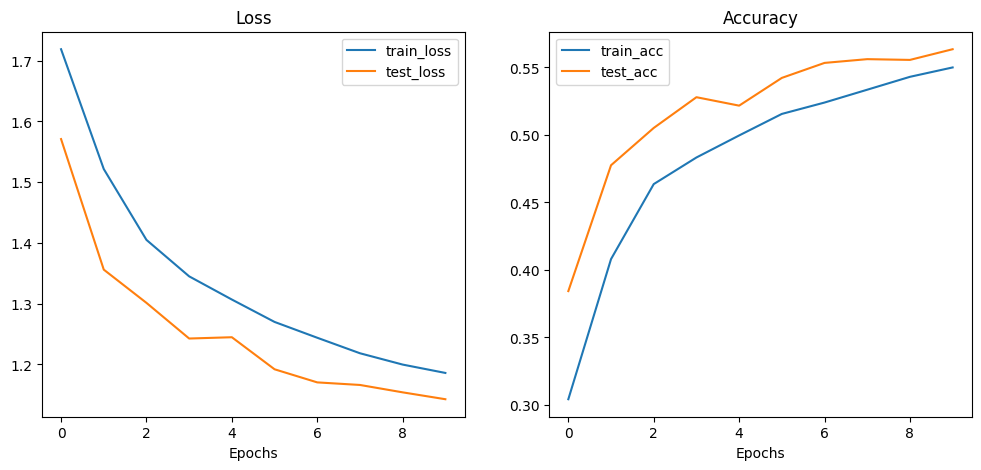

In [59]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict):
  """
  Returns separate loss curves for training and test metrics.
  """
  #get loss values from results
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  #get acc values from results
  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  #figure out number of epochs
  epochs = range(len(results["train_loss"]))

  #plot loss
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(epochs,train_loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc,label="train_acc")
  plt.plot(epochs,test_acc,label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()
plot_loss_curves(model_1_results)


MediumCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, inplace

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:28<13:34, 28.08s/it]

Epoch: 1/30 | Train Loss: 1.8255 | Train Acc: 0.2505 | Test Loss: 1.6877 | Test Acc: 0.3037


  7%|▋         | 2/30 [01:09<16:45, 35.91s/it]

Epoch: 2/30 | Train Loss: 1.6286 | Train Acc: 0.3479 | Test Loss: 1.4876 | Test Acc: 0.4393


 10%|█         | 3/30 [01:48<16:43, 37.17s/it]

Epoch: 3/30 | Train Loss: 1.5239 | Train Acc: 0.3989 | Test Loss: 1.4260 | Test Acc: 0.4486


 13%|█▎        | 4/30 [02:16<14:32, 33.56s/it]

Epoch: 4/30 | Train Loss: 1.4835 | Train Acc: 0.4148 | Test Loss: 1.3439 | Test Acc: 0.4890


 17%|█▋        | 5/30 [02:43<13:06, 31.47s/it]

Epoch: 5/30 | Train Loss: 1.4499 | Train Acc: 0.4245 | Test Loss: 1.3193 | Test Acc: 0.4974


 20%|██        | 6/30 [03:12<12:08, 30.34s/it]

Epoch: 6/30 | Train Loss: 1.4228 | Train Acc: 0.4367 | Test Loss: 1.2756 | Test Acc: 0.5126


 23%|██▎       | 7/30 [03:40<11:21, 29.61s/it]

Epoch: 7/30 | Train Loss: 1.4047 | Train Acc: 0.4393 | Test Loss: 1.2649 | Test Acc: 0.5177


 27%|██▋       | 8/30 [04:13<11:14, 30.67s/it]

Epoch: 8/30 | Train Loss: 1.3892 | Train Acc: 0.4469 | Test Loss: 1.2743 | Test Acc: 0.5189


 30%|███       | 9/30 [04:55<11:58, 34.21s/it]

Epoch: 9/30 | Train Loss: 1.3840 | Train Acc: 0.4483 | Test Loss: 1.2469 | Test Acc: 0.5322


 33%|███▎      | 10/30 [05:37<12:16, 36.84s/it]

Epoch: 10/30 | Train Loss: 1.3704 | Train Acc: 0.4542 | Test Loss: 1.2167 | Test Acc: 0.5368


 37%|███▋      | 11/30 [06:13<11:35, 36.60s/it]

Epoch: 11/30 | Train Loss: 1.3537 | Train Acc: 0.4642 | Test Loss: 1.2163 | Test Acc: 0.5381


 40%|████      | 12/30 [06:51<11:02, 36.82s/it]

Epoch: 12/30 | Train Loss: 1.3410 | Train Acc: 0.4663 | Test Loss: 1.2293 | Test Acc: 0.5321


 43%|████▎     | 13/30 [07:21<09:52, 34.83s/it]

Epoch: 13/30 | Train Loss: 1.3373 | Train Acc: 0.4735 | Test Loss: 1.2010 | Test Acc: 0.5428


 47%|████▋     | 14/30 [08:01<09:40, 36.30s/it]

Epoch: 14/30 | Train Loss: 1.3236 | Train Acc: 0.4791 | Test Loss: 1.1928 | Test Acc: 0.5442


 50%|█████     | 15/30 [08:43<09:32, 38.20s/it]

Epoch: 15/30 | Train Loss: 1.3164 | Train Acc: 0.4828 | Test Loss: 1.1643 | Test Acc: 0.5572


 53%|█████▎    | 16/30 [09:20<08:47, 37.71s/it]

Epoch: 16/30 | Train Loss: 1.3069 | Train Acc: 0.4884 | Test Loss: 1.1885 | Test Acc: 0.5569


 57%|█████▋    | 17/30 [09:49<07:38, 35.28s/it]

Epoch: 17/30 | Train Loss: 1.3006 | Train Acc: 0.4897 | Test Loss: 1.1866 | Test Acc: 0.5478


 60%|██████    | 18/30 [10:18<06:38, 33.17s/it]

Epoch: 18/30 | Train Loss: 1.2892 | Train Acc: 0.4972 | Test Loss: 1.1692 | Test Acc: 0.5616


 63%|██████▎   | 19/30 [11:01<06:36, 36.07s/it]

Epoch: 19/30 | Train Loss: 1.2766 | Train Acc: 0.5014 | Test Loss: 1.1446 | Test Acc: 0.5633


 67%|██████▋   | 20/30 [11:44<06:21, 38.20s/it]

Epoch: 20/30 | Train Loss: 1.2699 | Train Acc: 0.5069 | Test Loss: 1.1306 | Test Acc: 0.5677


 70%|███████   | 21/30 [12:28<05:59, 39.92s/it]

Epoch: 21/30 | Train Loss: 1.2534 | Train Acc: 0.5140 | Test Loss: 1.1619 | Test Acc: 0.5669


 73%|███████▎  | 22/30 [13:11<05:27, 40.94s/it]

Epoch: 22/30 | Train Loss: 1.2488 | Train Acc: 0.5193 | Test Loss: 1.1306 | Test Acc: 0.5765


 77%|███████▋  | 23/30 [13:54<04:51, 41.59s/it]

Epoch: 23/30 | Train Loss: 1.2401 | Train Acc: 0.5203 | Test Loss: 1.1293 | Test Acc: 0.5774


 80%|████████  | 24/30 [14:37<04:11, 41.89s/it]

Epoch: 24/30 | Train Loss: 1.2312 | Train Acc: 0.5229 | Test Loss: 1.1156 | Test Acc: 0.5851


 83%|████████▎ | 25/30 [15:02<03:04, 36.92s/it]

Epoch: 25/30 | Train Loss: 1.2262 | Train Acc: 0.5255 | Test Loss: 1.1182 | Test Acc: 0.5891


 87%|████████▋ | 26/30 [15:30<02:16, 34.13s/it]

Epoch: 26/30 | Train Loss: 1.2104 | Train Acc: 0.5310 | Test Loss: 1.1116 | Test Acc: 0.5843


 90%|█████████ | 27/30 [17:50<03:17, 65.97s/it]

Epoch: 27/30 | Train Loss: 1.2148 | Train Acc: 0.5301 | Test Loss: 1.0951 | Test Acc: 0.5958


 93%|█████████▎| 28/30 [21:54<03:59, 119.55s/it]

Epoch: 28/30 | Train Loss: 1.2056 | Train Acc: 0.5347 | Test Loss: 1.0889 | Test Acc: 0.5917


 97%|█████████▋| 29/30 [22:16<01:30, 90.25s/it] 

Epoch: 29/30 | Train Loss: 1.1965 | Train Acc: 0.5353 | Test Loss: 1.0944 | Test Acc: 0.5928


100%|██████████| 30/30 [22:38<00:00, 45.30s/it]

Epoch: 30/30 | Train Loss: 1.1953 | Train Acc: 0.5353 | Test Loss: 1.0765 | Test Acc: 0.5999
Total training time:  1358.981 seconds


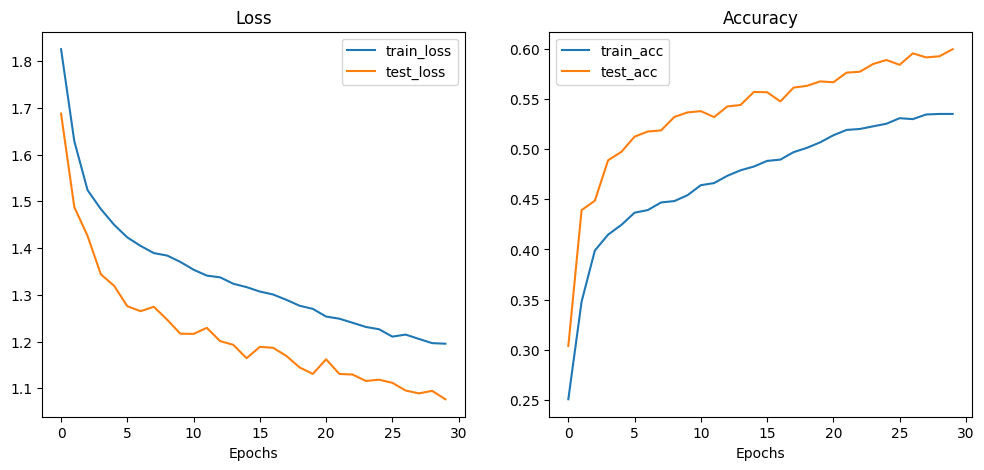

In [60]:
model_2 = MediumCNN(input_channels=3, num_classes=7).to(device)
print(model_2)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import time
NUM_EPOCHS = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
start_time = time.time()
model_2_results = train(model=model_2,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=device,
                        save_path="best_model_2.pth")
end_time = time.time()
print(f"Total training time: {end_time - start_time: .3f} seconds")
plot_loss_curves(model_2_results)


In [75]:
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path

# ----------------------------
# 1. Model and device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate your model (same architecture you trained)
model1 = TinyVGG(input_shape=3, hidden_units=32, output_shape=7).to(device)
model2 = MediumCNN(input_channels=3, num_classes=7).to(device)

# Load the trained weights
model1.load_state_dict(torch.load("best_model.pth", map_location=device))
model1.eval()

model2.load_state_dict(torch.load("best_model_2.pth", map_location=device))
model2.eval()

# Class names (adjust these to match your dataset)
class_names = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# ----------------------------
# 2. Define same transform as test data
# ----------------------------
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# ----------------------------
# 3. Predict on all images in folder
# ----------------------------
images_folder = Path(r"D:\Programming\Projects\Facial_Emotion_Recognition\images")  # your folder path

# Loop through all image files
for img_path in images_folder.glob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
        # Load image
        img = Image.open(img_path).convert("RGB")
        # Apply transforms
        img_tensor = transform(img).unsqueeze(0).to(device)
        # Predict
        with torch.inference_mode():
            output1 = model1(img_tensor)
            pred_class1 = torch.argmax(output1, dim=1).item()

            output2 = model2(img_tensor)
            pred_class2 = torch.argmax(output2, dim=1).item()

        # Print
        print(f"{img_path.name} : Model1: {class_names[pred_class1]} | Model2: {class_names[pred_class2]}")
    else:
        print(f"Skipped {img_path.name}, not a valid image file.")


angry.jpeg : Model1: angry | Model2: angry
fear.jpg : Model1: surprise | Model2: fear
fear2.jpg : Model1: neutral | Model2: fear
happy.jpeg : Model1: happy | Model2: happy
neutral.jpg : Model1: neutral | Model2: happy
sad.jpg : Model1: surprise | Model2: sad
surprise.jpeg : Model1: surprise | Model2: fear


In [65]:
from pathlib import Path
print("Current working directory:", Path.cwd())
print("Images folder exists:", Path("images").exists())


Current working directory: d:\Programming\Projects\Facial_Emotion_Recognition\model
Images folder exists: False


## Realtime Monitoring

In [80]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# -----------------------------
# Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = TinyVGG(input_shape=3, hidden_units=32, output_shape=7).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

model2 = MediumCNN(input_channels=3, num_classes=7).to(device)
model2.load_state_dict(torch.load("best_model_2.pth", map_location=device))
model2.eval()

# Emotion labels
class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Transform (same as training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# -----------------------------
# Initialize webcam and face detector
# -----------------------------
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

print("🎥 Starting real-time emotion detection... Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract face region
        face_img = frame[y:y+h, x:x+w]

        # Preprocess
        face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
        img_tensor = transform(face_pil).unsqueeze(0).to(device)

        # Prediction
        with torch.inference_mode():
            output = model(img_tensor)
            pred = torch.softmax(output, dim=1)
            pred_class = torch.argmax(pred, dim=1).item()
            confidence = torch.max(pred).item()

        # Draw box and label
        label = f"{class_names[pred_class]} ({confidence*100:.1f}%)"
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    cv2.imshow("Real-Time Facial Expression Monitor", frame)

    # Exit on 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("🛑 Stopped.")


🎥 Starting real-time emotion detection... Press 'q' to quit.
🛑 Stopped.
